In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from scipy.stats import linregress
# Define the ticker symbol
ticker_symbol = "TWD=x"

# Create a ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch intraday data (e.g., 1-minute interval)
intraday_data = ticker.history(period="60d", interval="15m")
intraday_data = intraday_data.astype('float')
# Display the data

intraday_data.to_csv('TWD_intraday.csv')
data=intraday_data.reset_index()

df = data.rename({'Datetime':'timestamp', 'Open':'price'}, axis=1)



In [14]:

# Ensure proper sorting
df = df.sort_values(by="timestamp")

# Extract time features
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['time_of_day'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60


<function matplotlib.pyplot.show(close=None, block=None)>

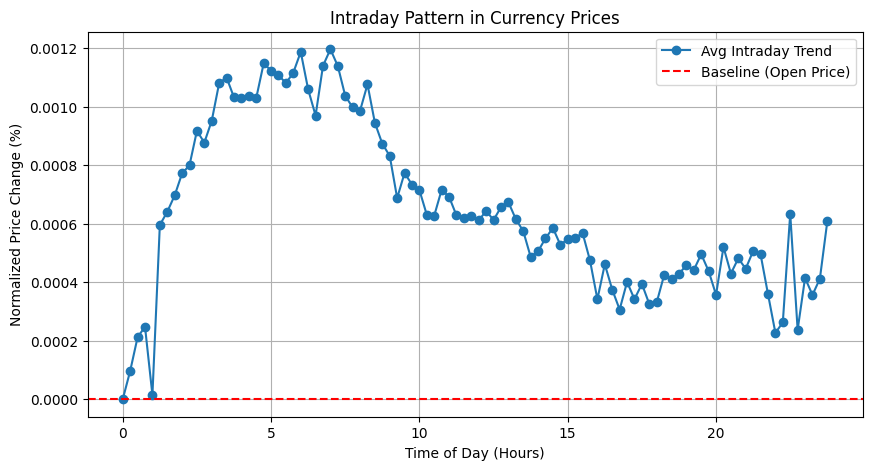

In [15]:

# Normalize prices by day
df['normalized_price'] = df.groupby('date')['price'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0])

# Compute daily average price trend
avg_trend = df.groupby('time_of_day')['normalized_price'].mean()

# Plot the intraday pattern
plt.figure(figsize=(10, 5))
plt.plot(avg_trend.index, avg_trend.values, marker="o", linestyle="-", label="Avg Intraday Trend")
plt.axhline(y=0, color="r", linestyle="--", label="Baseline (Open Price)")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Normalized Price Change (%)")
plt.title("Intraday Pattern in Currency Prices")
plt.legend()
plt.grid()
plt.show


In [16]:
# Check for mean reversion by correlating returns 
df['return'] = df['price'].pct_change()
df['prev_return'] = df['return'].shift(1)

correlation = df[['return', 'prev_return']].dropna().corr().iloc[0, 1]
print(f"Correlation between previous and current returns (Mean Reversion Indicator): {correlation:.4f}")


Correlation between previous and current returns (Mean Reversion Indicator): -0.2830


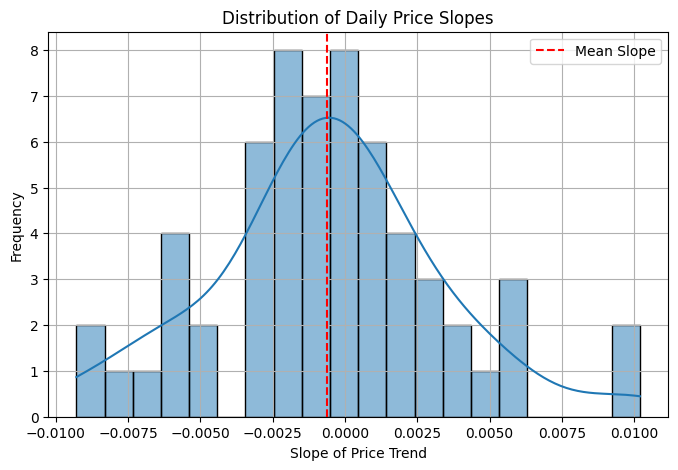

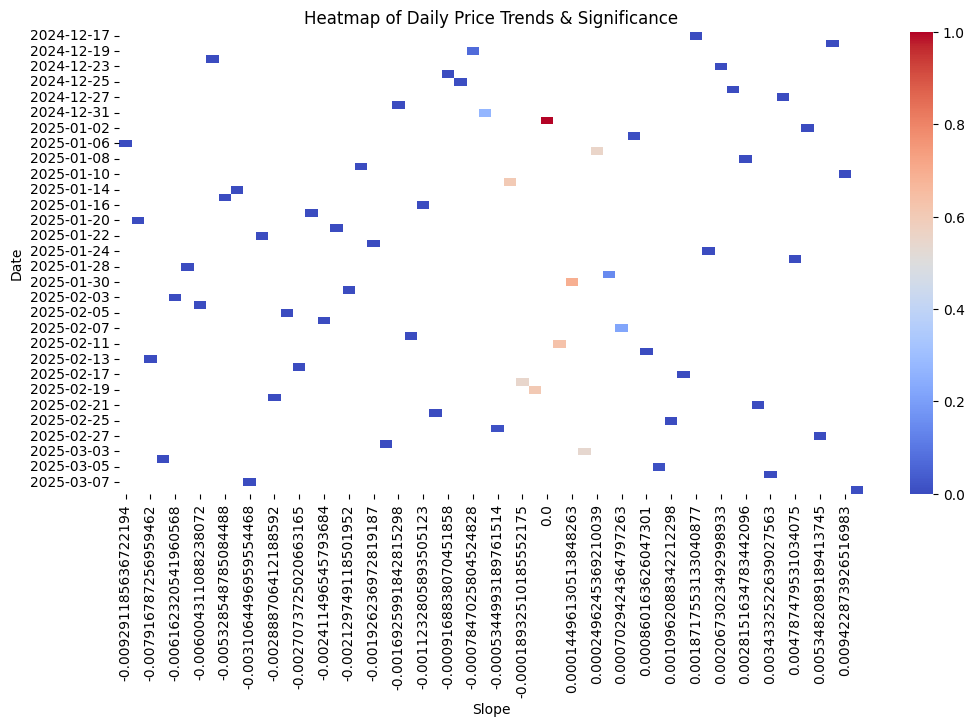

Significant upward/downward trends found in 48 out of 60 days (80.00%).


In [17]:
# Function to compute slope (trend) per day
def compute_daily_slope(data):
    slopes = []
    p_values = []
    for date, group in data.groupby('date'):
        x = group['time_of_day']
        y = group['price']
        if len(x) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            slopes.append(slope)
            p_values.append(p_value)
        else:
            slopes.append(np.nan)
            p_values.append(np.nan)
    
    return pd.DataFrame({'date': list(data['date'].unique()), 'slope': slopes, 'p_value': p_values})

# Compute daily slopes and significance
slope_df = compute_daily_slope(df)

# Plot histogram of slopes
plt.figure(figsize=(8, 5))
sns.histplot(slope_df['slope'].dropna(), bins=20, kde=True)
plt.axvline(slope_df['slope'].mean(), color='r', linestyle="--", label="Mean Slope")
plt.title("Distribution of Daily Price Slopes")
plt.xlabel("Slope of Price Trend")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Heatmap of daily slopes
plt.figure(figsize=(12, 6))
sns.heatmap(slope_df.pivot(index="date", columns="slope", values="p_value"), cmap="coolwarm", annot=False)
plt.title("Heatmap of Daily Price Trends & Significance")
plt.xlabel("Slope")
plt.ylabel("Date")
plt.show()

# Summary statistics
significant_days = (slope_df['p_value'] < 0.05).sum()
total_days = slope_df['p_value'].count()
print(f"Significant upward/downward trends found in {significant_days} out of {total_days} days ({(significant_days/total_days)*100:.2f}%).")



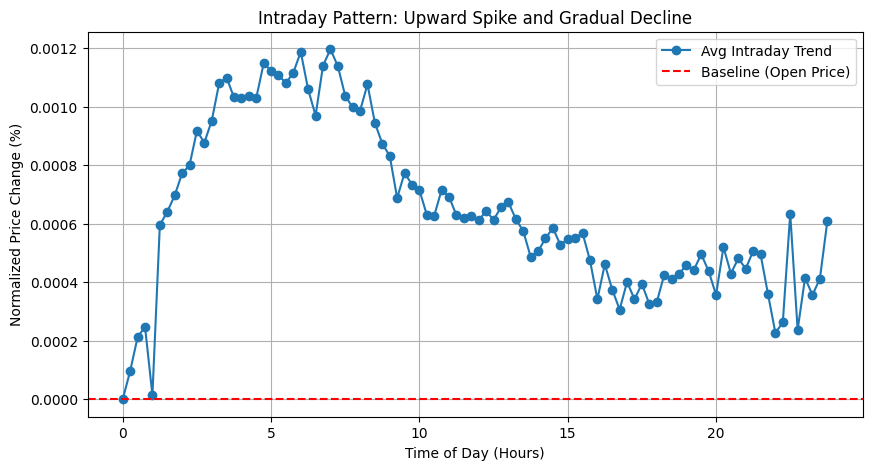

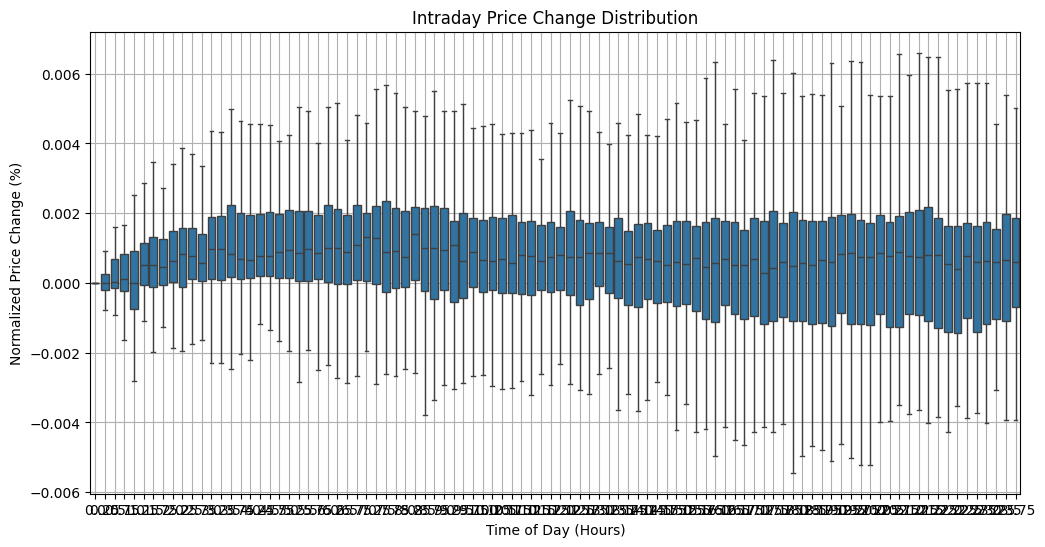

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Load data
# file_path = "your_currency_data.csv"  # Replace with actual file path
# df = pd.read_csv(file_path, parse_dates=['timestamp'])

# # Ensure proper sorting
# df = df.sort_values(by="timestamp")

# # Extract time features
# df['date'] = df['timestamp'].dt.date
# df['time_of_day'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60


# Compute the average normalized price across days
intraday_trend = df.groupby('time_of_day')['normalized_price'].mean()

# Plot the Intraday Trend
plt.figure(figsize=(10, 5))
plt.plot(intraday_trend.index, intraday_trend.values, marker="o", linestyle="-", label="Avg Intraday Trend")
plt.axhline(y=0, color="r", linestyle="--", label="Baseline (Open Price)")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Normalized Price Change (%)")
plt.title("Intraday Pattern: Upward Spike and Gradual Decline")
plt.legend()
plt.grid()
plt.show()

# Boxplot: Check Intraday Variability
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['time_of_day'], y=df['normalized_price'], showfliers=False)
plt.title("Intraday Price Change Distribution")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Normalized Price Change (%)")
plt.grid()
plt.show()



#### Attempt to prove using Standard Deviation

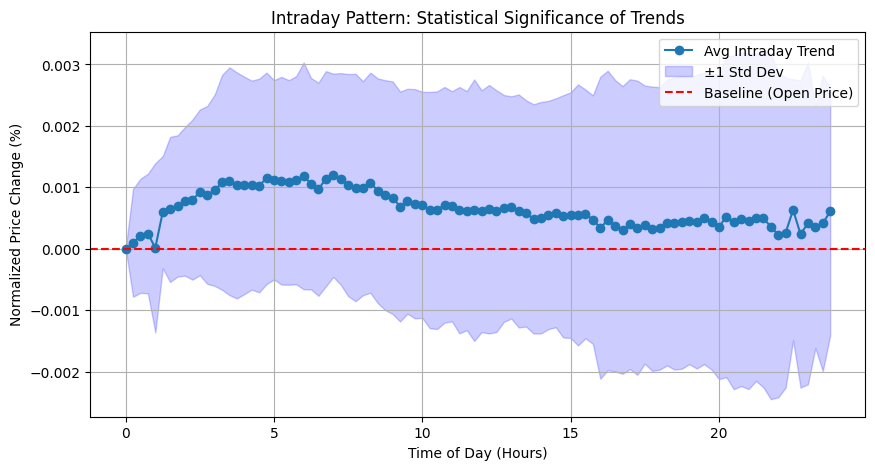

Morning surge exceeds 1 standard deviation in 0.00% of cases.
Afternoon decline stays within 1 standard deviation in 0.00% of cases.


In [19]:
# # Compute the average normalized price and standard deviation across days
intraday_trend = df.groupby('time_of_day')['normalized_price'].agg(['mean', 'std'])

# Define statistical significance threshold (1 std deviation)
upper_band = intraday_trend['mean'] + intraday_trend['std']
lower_band = intraday_trend['mean'] - intraday_trend['std']

# Plot Intraday Trend with Standard Deviation
plt.figure(figsize=(10, 5))
plt.plot(intraday_trend.index, intraday_trend['mean'], marker="o", linestyle="-", label="Avg Intraday Trend")
plt.fill_between(intraday_trend.index, lower_band, upper_band, color='blue', alpha=0.2, label="±1 Std Dev")
plt.axhline(y=0, color="r", linestyle="--", label="Baseline (Open Price)")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Normalized Price Change (%)")
plt.title("Intraday Pattern: Statistical Significance of Trends")
plt.legend()
plt.grid()
plt.show()

# Calculate significance: % of time morning surge exceeds 1 std deviation
morning_spike_time = intraday_trend.index[intraday_trend['mean'] > upper_band]
afternoon_fall_time = intraday_trend.index[intraday_trend['mean'] < lower_band]

morning_significance = len(morning_spike_time) / len(intraday_trend) * 100
afternoon_significance = len(afternoon_fall_time) / len(intraday_trend) * 100

print(f"Morning surge exceeds 1 standard deviation in {morning_significance:.2f}% of cases.")
print(f"Afternoon decline stays within 1 standard deviation in {afternoon_significance:.2f}% of cases.")


### Attempt to prove by looking at rolling windows
Key takeaways
1) Peak uptrend and downtrend
2) Adjust window size (w) => wx15min give windows

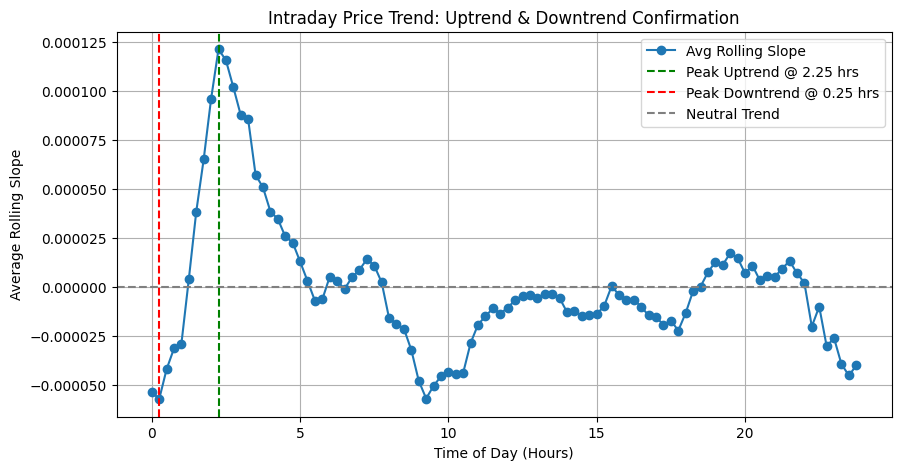

Morning positive slopes: 50.00% of the time
Afternoon negative slopes: 66.67% of the time


In [20]:

import seaborn as sns
from scipy.stats import linregress

window_size = 10  # Adjust based on frequency of data (e.g., 10-minute windows)
df['rolling_slope'] = df['normalized_price'].rolling(window=window_size).apply(
    lambda y: linregress(range(len(y)), y).slope if len(y) == window_size else np.nan, raw=True
)

# Compute average slope by time of day
intraday_slope = df.groupby('time_of_day')['rolling_slope'].mean()

# Identify times of significant slope changes
morning_peak = intraday_slope.idxmax()  # Time of highest slope (steepest increase)
afternoon_fall = intraday_slope.idxmin()  # Time of lowest slope (steepest decrease)

# Plot Intraday Rolling Slope Trend
plt.figure(figsize=(10, 5))
plt.plot(intraday_slope.index, intraday_slope.values, marker="o", linestyle="-", label="Avg Rolling Slope")
plt.axvline(morning_peak, color="g", linestyle="--", label=f"Peak Uptrend @ {morning_peak:.2f} hrs")
plt.axvline(afternoon_fall, color="r", linestyle="--", label=f"Peak Downtrend @ {afternoon_fall:.2f} hrs")
plt.axhline(y=0, color="gray", linestyle="--", label="Neutral Trend")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Average Rolling Slope")
plt.title("Intraday Price Trend: Uptrend & Downtrend Confirmation")
plt.legend()
plt.grid()
plt.show()

# Compute percentage of positive vs negative slopes in morning & afternoon
morning_slopes = intraday_slope[intraday_slope.index < 12]  # Before noon
afternoon_slopes = intraday_slope[intraday_slope.index >= 12]  # After noon

morning_positive_pct = (morning_slopes > 0).sum() / len(morning_slopes) * 100
afternoon_negative_pct = (afternoon_slopes < 0).sum() / len(afternoon_slopes) * 100

print(f"Morning positive slopes: {morning_positive_pct:.2f}% of the time")
print(f"Afternoon negative slopes: {afternoon_negative_pct:.2f}% of the time")


Morning Trend: t-statistic = 4.9823, p-value = 0.0000
Afternoon Trend: t-statistic = -2.5756, p-value = 0.0125


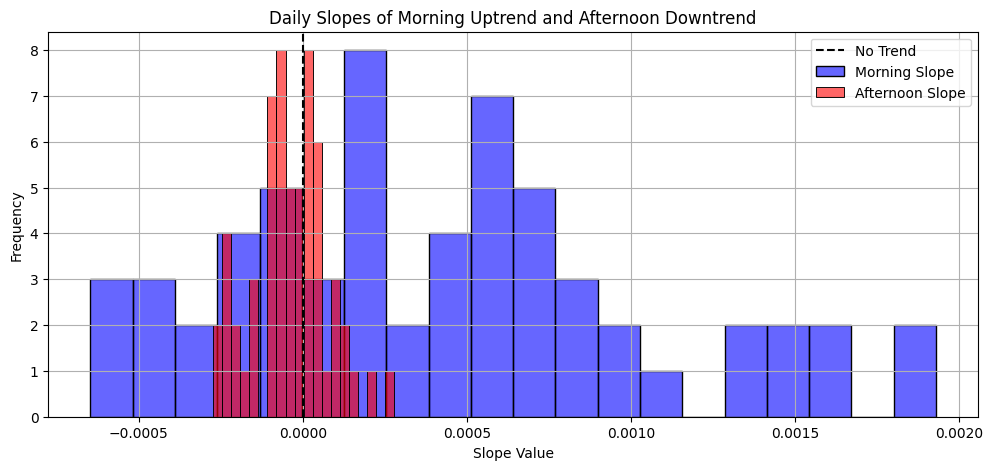

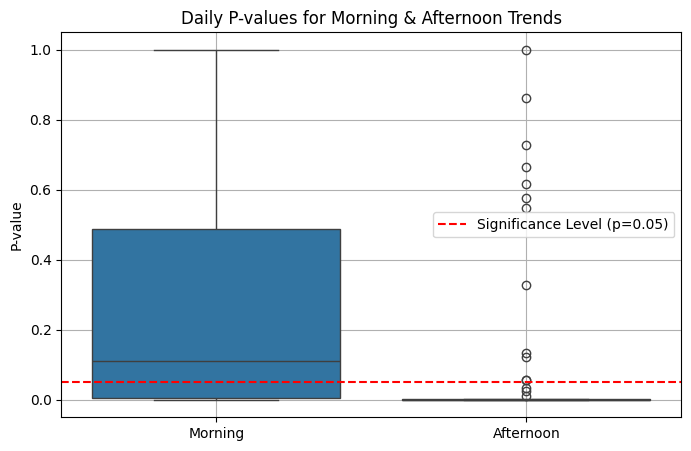

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_1samp

# # Load data
# file_path = "your_currency_data.csv"  # Replace with actual file path
# df = pd.read_csv(file_path, parse_dates=['timestamp'])

# # Ensure proper sorting
# df = df.sort_values(by="timestamp")

# # Filter for last 3 months
# df = df[df['timestamp'] >= df['timestamp'].max() - pd.DateOffset(months=3)]

# # Extract time features
# df['date'] = df['timestamp'].dt.date
# df['time_of_day'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60

# Normalize prices by each day (relative change from open)
df['normalized_price'] = df.groupby('date')['price'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0])

# Function to compute daily slope & p-value
def compute_daily_stats(data):
    results = []
    for date, group in data.groupby('date'):
        morning = group[group['time_of_day'] < 2.25]  # Morning session
        afternoon = group[group['time_of_day'] >= 2.25]  # Afternoon session
        
        # Compute slope for morning
        if len(morning) > 1:
            slope_morning, _, _, p_value_morning, _ = linregress(morning['time_of_day'], morning['normalized_price'])
        else:
            slope_morning, p_value_morning = np.nan, np.nan

        # Compute slope for afternoon
        if len(afternoon) > 1:
            slope_afternoon, _, _, p_value_afternoon, _ = linregress(afternoon['time_of_day'], afternoon['normalized_price'])
        else:
            slope_afternoon, p_value_afternoon = np.nan, np.nan

        results.append({
            'date': date,
            'slope_morning': slope_morning,
            'p_value_morning': p_value_morning,
            'slope_afternoon': slope_afternoon,
            'p_value_afternoon': p_value_afternoon
        })

    return pd.DataFrame(results)

# Compute daily statistics
daily_stats = compute_daily_stats(df)

# Conduct t-test on morning & afternoon slopes
morning_tstat, morning_p = ttest_1samp(daily_stats['slope_morning'].dropna(), 0)
afternoon_tstat, afternoon_p = ttest_1samp(daily_stats['slope_afternoon'].dropna(), 0)

print(f"Morning Trend: t-statistic = {morning_tstat:.4f}, p-value = {morning_p:.4f}")
print(f"Afternoon Trend: t-statistic = {afternoon_tstat:.4f}, p-value = {afternoon_p:.4f}")

# Plot daily slopes and significance
plt.figure(figsize=(12, 5))
sns.histplot(daily_stats['slope_morning'].dropna(), bins=20, color='blue', label="Morning Slope", alpha=0.6)
sns.histplot(daily_stats['slope_afternoon'].dropna(), bins=20, color='red', label="Afternoon Slope", alpha=0.6)
plt.axvline(0, color="black", linestyle="--", label="No Trend")
plt.xlabel("Slope Value")
plt.ylabel("Frequency")
plt.title("Daily Slopes of Morning Uptrend and Afternoon Downtrend")
plt.legend()
plt.grid()
plt.show()

# Boxplot of p-values to check significance across days
plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_stats[['p_value_morning', 'p_value_afternoon']])
plt.axhline(0.05, color="r", linestyle="--", label="Significance Level (p=0.05)")
plt.title("Daily P-values for Morning & Afternoon Trends")
plt.ylabel("P-value")
plt.xticks([0, 1], ['Morning', 'Afternoon'])
plt.legend()
plt.grid()
plt.show()
